# Working with time series, frequency series, and unit conversion

In this notebook, we show some of the most useful features of the [timeseries](../series.rst) module. To do so, we will analyze a fake gravitational-wave signal. We will also show the [frequencyseries](../series.rst) module and the [unitconv](../unitconv.rst) modules.

First, let's generate this signal. 

(This notebook is meant to be converted in Sphinx documentation and not used directly.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from kuibit import timeseries as ts
from kuibit import series
from kuibit import unitconv as uc
from kuibit.gw_utils import luminosity_distance_to_redshift

%matplotlib inline

In [2]:
t = np.linspace(0, 20, 5000)
y = np.sin(t)

# Generate a TimeSeries by providing the times and the values of the series
gw = ts.TimeSeries(t, y)

To access the times and the values, use ``gw.t`` and ``gw.y``. 

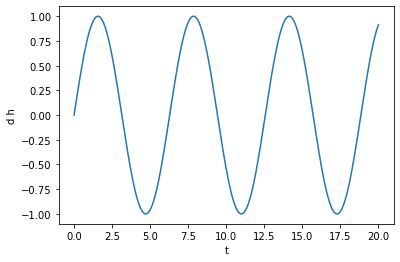

In [3]:
def plot(ser, lab1="d h", lab2="t", *args, **kwargs):
    """Plot Series ser with labels"""
    plt.ylabel(lab1)
    plt.xlabel(lab2)
    plt.plot(ser, *args, **kwargs)
    
plot(gw)

Let's make this more interesting: we square the signal and add Gaussian noise. [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) support directly using all the basic mathematical operations in Python and NumPy, so we can easily square the signal and add another TimeSeries to it.

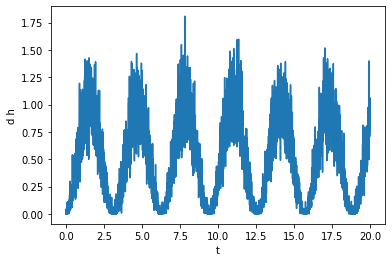

In [4]:
noise = np.random.normal(0, 0.1, len(gw))  # Here we used len() on the TimeSeries
noise_ts = ts.TimeSeries(t, noise)

gw += noise_ts
gw **= 2

plot(gw)

To analyze this signal, first we will smooth it. To do that, we will use the [savgol_smooth_time](../timeseries_ref.html#kuibit.timeseries.TimeSeries.savgol_smooth_time) method, which is a generalized "running average" filter. This method requires length of time over which we want to smooth the data.

In [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) there are always two different methods to do the same task, one with imperative verb (e.g., smooth), and the other with the past tense (e.g., smoothed). The first modifies the data, the second returns a new `TimeSeries` with the operation applied. Here, we will find what smoothing length to use by trial and error, so we will use the second method. 

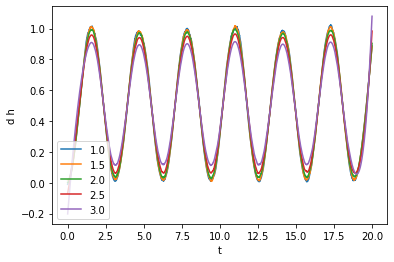

In [5]:
tsmooth = np.linspace(1, 3, 5)

for tsm in tsmooth:
    smoothed = gw.savgol_smoothed_time(tsm)
    plot(smoothed, label=tsm)
plt.legend()

From visual inspection it looks like that ``tsmooth = 1.5`` will work yield a clean series faithful to the original one.

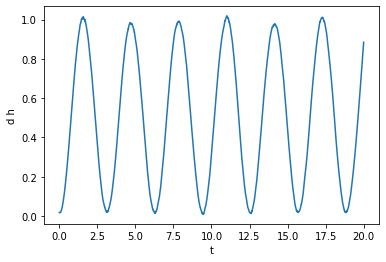

In [6]:
gw.savgol_smooth_time(1.5)
plot(gw)

Next, for fun, we can compute integrals and derivatives. For instance, we can compute what is the integral from 5 to 10.

The integral from 5 to 10 is 2.1787


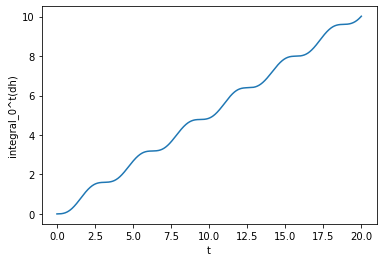

In [7]:
gw_int = gw.integrated()
a = 5
b = 10
print(f"The integral from {a} to {b} is {gw_int(b) - gw_int(a):.4f}")
plot(gw_int, lab1="integral_0^t(dh)")

Here, we showed a very powerful feature of `TimeSeries`: you can call them on a specific time (as we did we ``gw_int(b)``). This is done using splines to interpolate to the points that are not available. Splines can also be used to take derivatives. Alternatively, one can simply take the finite (central) difference. Let's see what's the derivative of ``gw`` using splines and finite difference.

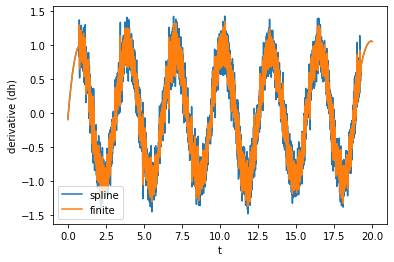

In [8]:
gw_spline_der = gw.spline_differentiated()
gw_numer_der = gw.differentiated()

plot(gw_spline_der, label='spline')
plot(gw_numer_der, lab1="derivative (dh)", label='finite')
plt.legend()

Clearly, derivatives will be noisier than the actual data, so often it is convenient to smooth them out as shown before.

TimeSeries support complex signals. Now, we will create one using `gw` itself. We will copy `gw`, time-shift it, find the common time interval with the original `gw`, and use that as a the imaginary part.

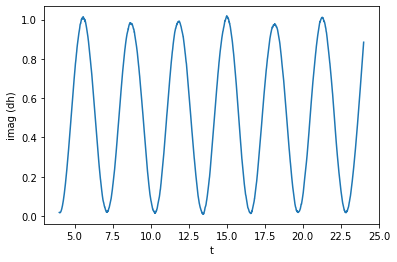

In [9]:
gw_imag = gw.copy()  # It is important to deep copy the object
gw_imag.time_shift(4)

plot(gw_imag, lab1 ="imag (dh)")

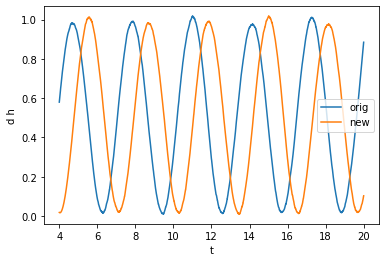

In [10]:
gw, gw_imag = series.sample_common([gw, gw_imag], resample=True)  # Resampling to common times

plot(gw, label="orig")
plot(gw_imag, label="new")
plt.legend()

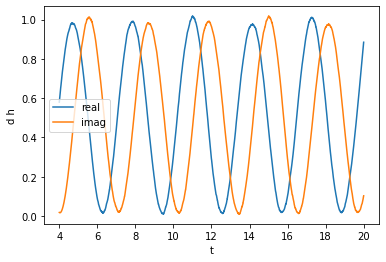

In [11]:
gw_complex = ts.TimeSeries(gw.t, gw.y + 1j * gw_imag.y)

plot(gw_complex.real(), label="real")
plot(gw_complex.imag(), label="imag")
plt.legend()

We can also compute the phase and absolute value. In particular, we will compute the unfolded phase (no wrapping over $2\pi$)

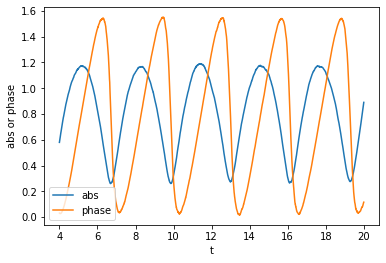

In [12]:
plot(gw_complex.abs(), label='abs')
plot(gw_complex.unfolded_phase(), lab1="abs or phase", label='phase')
plt.legend()

Here, the unfolded phase looks a little bit unusual. This is because we made up the signal.

We can also compute the frequency of the phase, which we can directly smooth.

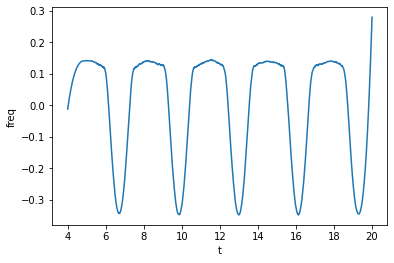

In [13]:
plot(gw_complex.phase_frequency(tsmooth=1.5), lab1="freq")

Next, we will take a Fourier transform. Before, let's pretend that the signal was in geometrized units (as in simulations), and let's make it physical assuming a scale of $M = 1 M_\odot$. For that, use the [unitconv](../unitconv.rst) module. We define a CU object that knows how to convert units.

In [14]:
CU = uc.geom_umass_msun(1) 

# How to convert from geometrized length to physical length?
# Simply multiply times CU.length. Let's check that it is 1.477 km
CU.length  # m

1476.6436994724972

Now we rescale `gw`, assuming that `y` is strain times distance (as usually is). Let's assume a distance of 500 Mpc.

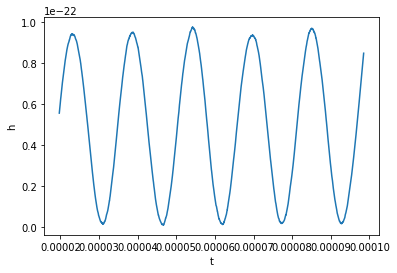

In [15]:
d_Mpc = 500

# inverse = True means from geometrized to physical
gw_physical = gw_complex.time_unit_changed(CU.time, inverse=True)  

gw_physical *= CU.length  # dh -> dh physical
# Now just the strain, since we assume a distance
gw_physical /= (d_Mpc * uc.MEGAPARSEC_SI)

# We have to manually add the redshift
gw_physical.redshifted(luminosity_distance_to_redshift(d_Mpc))

plot(gw_physical.real(), lab1="h")

Okay, now before taking the Fourier transform, we will remove the mean and window our signal. A Tukey window will work.

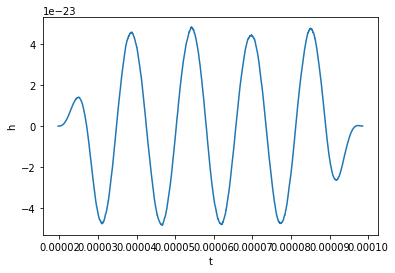

In [16]:
gw_physical.mean_remove()
gw_physical.tukey_window(0.3)
plot(gw_physical.real(), lab1="h")

Finally, we can take the Fourier transform. This is easy to do:

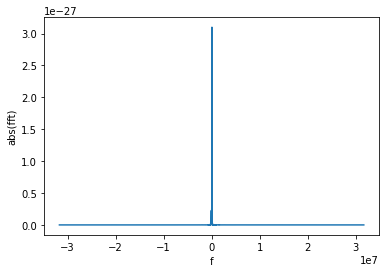

In [17]:
gw_fft = gw_physical.to_FrequencySeries()

# Plotting the amplitude of the Fourier transform
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

The new object is a `FrequencySeries`. It is very similar to a `TimeSeries` and it shares several properties, methods, and features. 

Let's restrict to only positive frequencies close to zero.

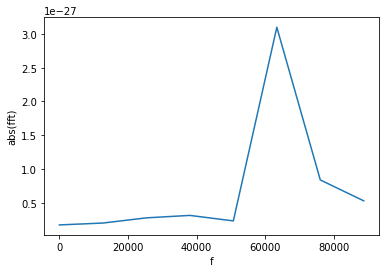

In [18]:
gw_fft.crop(0, 1e5)
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

We can find the frequency of that peak! For this, we find all the peaks with amplitude larger than 1e-27.

Frequency: 64181.81


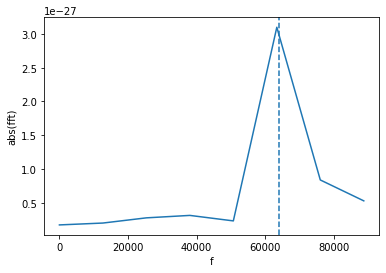

In [19]:
f_peak = gw_fft.peaks_frequencies(1e-27)[0]

print(f"Frequency: {f_peak:.2f}")
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")
plt.axvline(f_peak, ls = 'dashed')

The line is not on the maximum because we use a quadratic interpolation to find a more accurate location of the peak.